In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data',train=True,download=True,transform=transform)

C:\Users\burak\anaconda3\envs\pytorchenv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
test_data = datasets.MNIST(root='../Data',train=False,download=True,transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10, shuffle=False)

In [8]:
# 1 Color Channel, 6 Filters (Output Channels), 3by3 Kernel, Stride=1
conv1 = nn.Conv2d(1,6,3,1)
# 1 color channel --> 6 filters output channel feature extraction --> 3by3 3x3 kernel(matrix) size --> 1 stride step size

# ---> 6 filters --> pooling -->conv2


# 6 input filters Conv1, 16 filters(output channel), 3x3, stride = 1
conv2 = nn.Conv2d(6,16,3,1)  

In [9]:
for i ,(X_train,y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape 

torch.Size([1, 28, 28])

In [15]:
x = X_train.view(1,1,28,28) # ---> 4D batch(batch of 1 image)

In [16]:
x = F.relu(conv1(x))

In [17]:
x.shape # the main issue is 1 grayscale 6 output but why is there 26 26 instead of 28 28
# because with filters 3x3 matrix we can lose borders(padding = 0) 

torch.Size([1, 6, 26, 26])

In [18]:
x = F.max_pool2d(x,2,2) # kernel size and stride

In [19]:
x.shape # with 2 stride we are cutting half the image with pooling

torch.Size([1, 6, 13, 13])

In [20]:
x = F.relu(conv2(x))

In [21]:
x.shape

torch.Size([1, 16, 11, 11])

In [22]:
x = F.max_pool2d(x,2,2)

In [23]:
x.shape

torch.Size([1, 16, 5, 5])

In [25]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

In [26]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)
        
        

In [28]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [29]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [31]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed        

epoch:  0  batch:  600 [  6000/60000]  loss: 0.27711093  accuracy:  74.583%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.05912347  accuracy:  83.725%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.17079256  accuracy:  87.467%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.13591507  accuracy:  89.654%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.01328905  accuracy:  91.023%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.01176713  accuracy:  91.906%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00790256  accuracy:  92.605%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00256785  accuracy:  93.167%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00175660  accuracy:  93.639%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00351464  accuracy:  94.055%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.04854865  accuracy:  97.817%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.06619741  accuracy:  97.967%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00453133  accuracy:  98.022%
epoch:  1  b

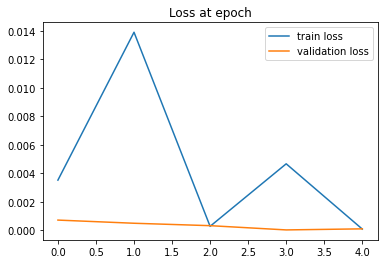

In [33]:
plt.plot(train_losses,label="train loss")
plt.plot(test_losses,label="validation loss")
plt.title("Loss at epoch")
plt.legend()

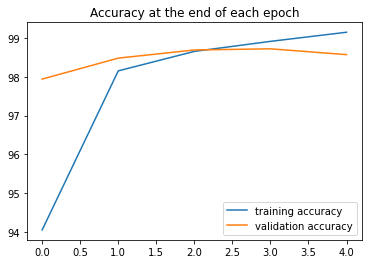

In [34]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [35]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [36]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9857/10000 =  98.570%


In [37]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 976    0    0    2    0    3    4    1    4    1]
 [   0 1125    0    0    0    0    1    4    0    0]
 [   0    2 1024   10    2    0    0    9    2    2]
 [   0    0    0  989    0    7    0    1    2    1]
 [   0    0    0    0  966    0    2    0    0    2]
 [   0    1    0    3    0  880    4    1    3    5]
 [   2    3    1    0    5    1  946    0    1    1]
 [   1    0    3    1    0    1    0 1002    0    3]
 [   0    4    3    4    1    0    1    5  961    6]
 [   1    0    1    1    8    0    0    5    1  988]]


In [38]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

143

In [39]:
# Display the first 10 index positions
misses[:10]

array([  18,   62,  115,  247,  321,  340,  445,  582,  625,  646],
      dtype=int64)

In [40]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [  18   62  115  247  321  340  445  582  625  646  674  846]
Label: [   3    9    4    4    2    5    6    8    6    2    5    7]
Guess: [   2    5    9    2    7    3    0    2    4    6    3    9]


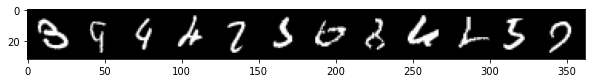

In [41]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

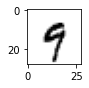

In [42]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [43]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9
